In [3]:
import numpy as np
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import random
from albumentations import (
    HorizontalFlip, RandomRotate90, Transpose, RandomBrightnessContrast,  Compose, VerticalFlip,HorizontalFlip, IAAAdditiveGaussianNoise)

In [7]:
big_nodules = np.load('..\\lidc_idri_preproc\\nods_3more_data.npy')
small_nodules = np.load('..\\lidc_idri_preproc\\all_small_nodes.npy')
non_nodules = np.load('..\\lidc_idri_preproc\\all_nnds.npy')

In [8]:
test = []
for i in small_nodules:
    test.append(np.max(i))
#np.max(big_nodules), np.max(small_nodules), np.max(non_nodules), np.min(big_nodules), np.min(small_nodules), np.min(non_nodules)
print(st.mode(big_nodules, axis=None, keepdims=False))

ModeResult(mode=-1024, count=152809)


In [7]:
(small_nodules < -1024).sum(), (small_nodules > -1024).sum()

(297, 63979213)

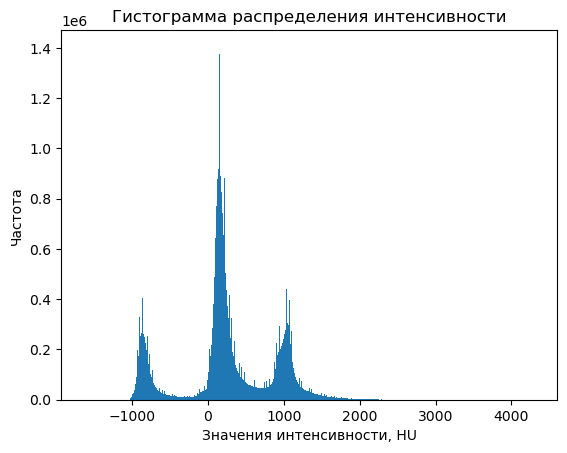

In [8]:

k = np.concatenate((big_nodules, small_nodules, non_nodules))#big_nodules
_ = plt.hist(k.reshape(167477248, 1), bins='auto')  # arguments are passed to np.histogram
plt.title("Гистограмма распределения интенсивности")
plt.ylabel('Частота')
plt.xlabel('Значения интенсивности, HU')
plt.show()

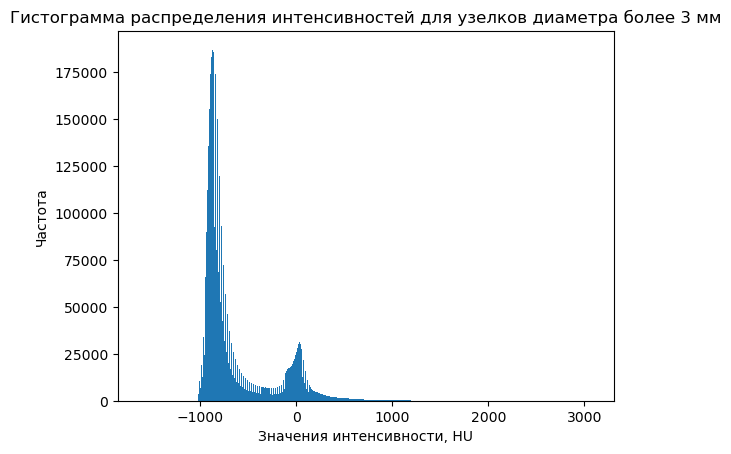

In [9]:

k = np.concatenate((big_nodules))#big_nodules
_ = plt.hist(k.reshape(22642688, 1), bins='auto')  # arguments are passed to np.histogram
plt.title("Гистограмма распределения интенсивностей для узелков диаметра более 3 мм")
plt.ylabel('Частота')
plt.xlabel('Значения интенсивности, HU')
plt.show()

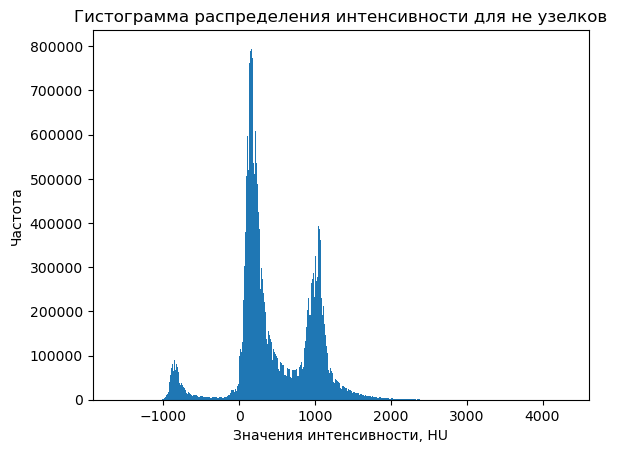

In [10]:
k = np.concatenate((non_nodules))#big_nodules
_ = plt.hist(k.reshape(80855040, 1), bins='auto')  # arguments are passed to np.histogram
plt.title("Гистограмма распределения интенсивности для не узелков")
plt.ylabel('Частота')
plt.xlabel('Значения интенсивности, HU')
plt.show()

In [736]:
np.save("small_nodules_normalize", small_nodules_normalize)
np.save("non_nodules_normalize", non_nodules_normalize)

In [9]:
"""Normalize the volume"""
def normalize(volume):
    min = -1024
    max = 2000

    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume
big_nodules_normalize = normalize(big_nodules)
small_nodules_normalize = normalize(small_nodules)
non_nodules_normalize = normalize(non_nodules)

In [97]:
non_nodules_normalize.shape

(4935, 32, 32, 16)

In [20]:
import cv2

In [744]:
augm = Compose([
        RandomRotate90(p=0.5),
        Transpose(p=0.5),
#         ShiftScaleRotate(shift_limit=0.0, scale_limit=0.50, rotate_limit=0, border_mode=cv2.BORDER_CONSTANT, p=.75),
        RandomBrightnessContrast(brightness_limit=0.11, contrast_limit=0.4, p=0.7),  
    VerticalFlip(p=0.7),HorizontalFlip(p=0.7), IAAAdditiveGaussianNoise(scale = [0, 0.013], p = 0.7)
        #RandomScale(scale_limit=0.3)
    ])

c:\Users\stan_\lidc-idri-preproc\diploma_work\EfficientNet\.conda\lib\site-packages\albumentations\imgaug\transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


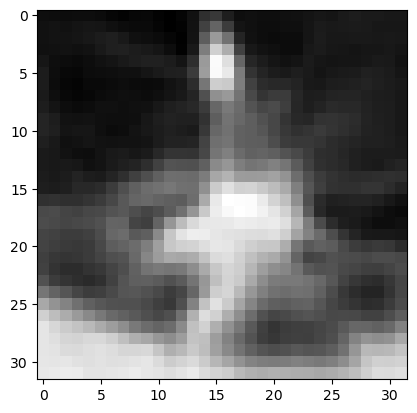

In [719]:
plt.imshow(big_nodules_normalize[textures[textures['int_texture'] == 4].index.values[30], :, :, 8], 'gray')

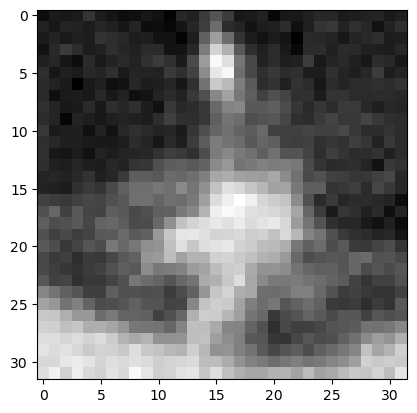

In [729]:
image = augm(image=big_nodules_normalize[textures[textures['int_texture'] == 4].index.values[30], :, :, 8])['image']
plt.imshow(image, 'gray')

In [734]:
textures[textures['int_texture'] == 4].index

Int64Index([   1,   12,   18,   24,   27,   33,   39,   40,   44,   45,
            ...
            1306, 1307, 1309, 1320, 1328, 1330, 1331, 1346, 1353, 1370],
           dtype='int64', length=253)

In [735]:
for i in range(1, 6):
    np.save("texture" + str(i), big_nodules_normalize[textures[textures['int_texture'] == i].index.values])

In [749]:
import random

texture1 = np.load("texture1.npy")
texture2 = np.load("texture2.npy")
texture3 = np.load("texture3.npy")
texture4 = np.load("texture4.npy")
texture5 = np.load("texture5.npy")
all_textures = [texture1, texture2, texture3, texture4, texture5]

non_nodules_normalize

def split_data(data, exclude_part):
    test = data[int(data.shape[0]*(exclude_part - 1)/10):int(data.shape[0]*(exclude_part)/10)]
    if exclude_part < 10:
        val = data[int(data.shape[0]*(exclude_part)/10):int(data.shape[0]*(exclude_part + 1)/10)]
        if exclude_part > 1:
            train = np.concatenate((data[:int(data.shape[0]*(exclude_part - 1)/10)], data[int(data.shape[0]*(exclude_part+1)/10):]), axis = 0)
        else:
            train = data[int(data.shape[0]*(exclude_part + 1)/10):]
    else:
        choose_val_part = random.randint(1, 8)
        val = data[int(data.shape[0]*(choose_val_part - 1)/10):int(data.shape[0]*(choose_val_part)/10)]

        if choose_val_part > 1:
            train = np.concatenate((data[:int(data.shape[0]*(choose_val_part - 1)/10)], data[int(data.shape[0]*(choose_val_part)/10):int(data.shape[0]*(exclude_part - 1)/10)]), axis = 0)
        else:
            train = np.concatenate(data[int(data.shape[0]*(choose_val_part)/10):int(data.shape[0]*(exclude_part - 1)/10)])
    return train, test, val

def aug_data(data, texture = True):

    k = 5
    if not texture: k = 1

    mult = int((non_nodules_normalize.shape[0]*0.8)//k)
    extra = int((non_nodules_normalize.shape[0]*0.8)%k)
    res = []
    for i in data:
        res.append(i)
        for j in range(mult - 1):
            res.append(augm(image = i)['image'])
    for i in range(extra):
        ind = random.randint(0, data.shape[0])
        res.append(augm(image = i)['image'])

    print(data.shape[0], len(res))
    return np.random.shuffle(np.array(res))

X_train, X_val, X_test, y_train, y_val, y_test, add_train, add_test, add_val = [], [], [], [], [], [], [], [], []
for i in range(1, 11):
    for j in range(5):
        train, test, val = split_data(all_textures[j], i)
        trainAug = aug_data(train)
        X_train.append(trainAug)
        X_val.append(val)
        X_test.append(test)

        y_train.append(np.full((1, trainAug.shape[0]), 0))
        y_val.append(np.full((1, val.shape[0]), 0))
        y_test.append(np.full((1, test.shape[0]), 0))
        
        add_train.append(np.full((1, trainAug.shape[0]), j+1))
        add_val.append(np.full((1, val.shape[0]), j+1))
        add_test.append(np.full((1, test.shape[0]), j+1))

    train, test, val = split_data(small_nodules_normalize, i)
    trainAug = aug_data(train)
    X_train.append(trainAug)
    X_val.append(val)
    X_test.append(test)

    y_train.append(np.full((1, trainAug.shape[0]), 1))
    y_val.append(np.full((1, val.shape[0]), 1))
    y_test.append(np.full((1, test.shape[0]), 1))

    add_train.append(np.full((1, trainAug.shape[0]), -1))
    add_val.append(np.full((1, val.shape[0]), -1))
    add_test.append(np.full((1, test.shape[0]), -1))

    train, test, val = split_data(non_nodules_normalize, i)
    X_train.append(train)
    X_val.append(val)
    X_test.append(test)

    y_train.append(np.full((1, train.shape[0]), 2))
    y_val.append(np.full((1, val.shape[0]), 2))
    y_test.append(np.full((1, test.shape[0]), 2))

    add_train.append(np.full((1, train.shape[0]), -1))
    add_val.append(np.full((1, val.shape[0]), -1))
    add_test.append(np.full((1, test.shape[0]), -1))


TypeError: image must be numpy array type

In [ ]:
X_tr = X_train[0]


In [ ]:
for i in big_nodules_normalize[203, :, :, 8]:
    image = augm(image=)['image']
    print(type(image))
    break

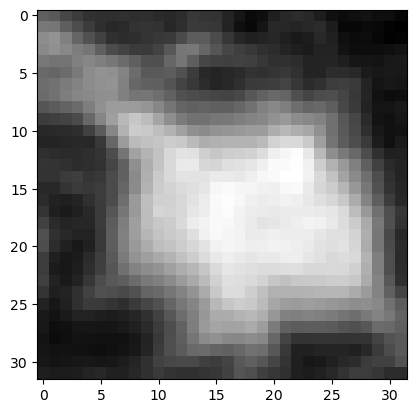

In [152]:
plt.imshow(big_nodules_normalize[0][:, :, 7], 'gray')

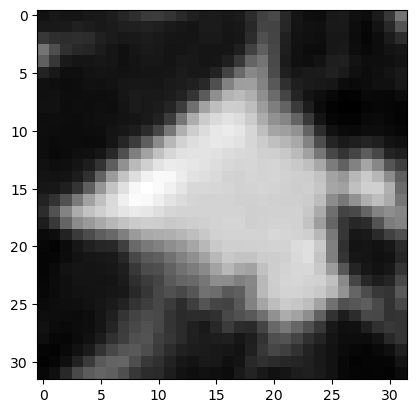

In [196]:
plt.imshow(non_nodules_normalize[123][:, :, 8], 'gray')

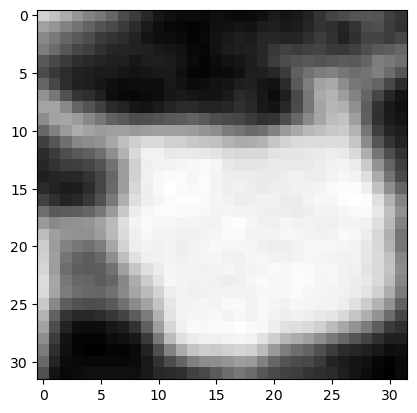

In [153]:
plt.imshow(big_nodules_normalize[0][:, :, 9], 'gray')

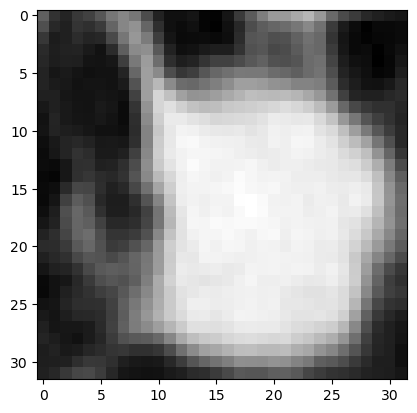

In [56]:
plt.imshow(image[:, :, 8], 'gray')

In [4]:
big_nodules.shape, small_nodules.shape, non_nodules.shape

((1382, 32, 32, 16), (3905, 32, 32, 16), (4935, 32, 32, 16))

In [173]:
x = ['Узелки малого диаметра', 'Узелки большего диаметра', "Не узелки"]
y = [big_nodules.shape[0], small_nodules.shape[0], non_nodules.shape[0]]
df = pd.DataFrame(data = np.array(y).reshape(1, 3), columns = x)
df

,Узелки малого диаметра,Узелки большего диаметра,Не узелки
0,1382,3905,4935


In [181]:
df

,Количество экземпляров класса,Классы
0,1382,Узелки малого диаметра
1,3905,Узелки большего диаметра
2,4935,Не узелки


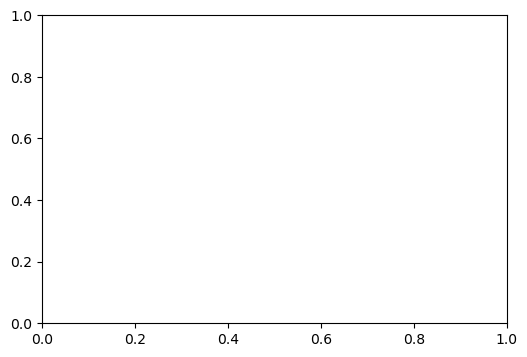

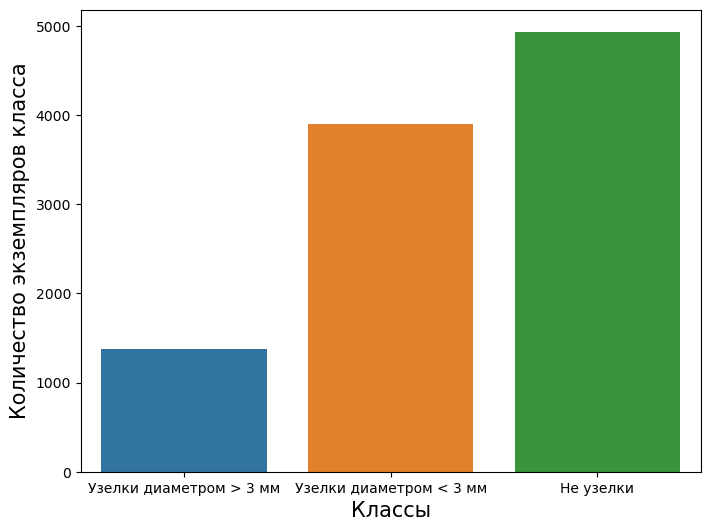

In [184]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

x = ['Узелки диаметром > 3 мм', 'Узелки диаметром < 3 мм', "Не узелки"]
y = [big_nodules.shape[0], small_nodules.shape[0], non_nodules.shape[0]]
df = pd.DataFrame(data = y, columns = ['Количество экземпляров класса'])
df['Классы'] = x

# Defining the plotsize
plt.figure(figsize=(8, 6))
 
# Defining the x-axis, the y-axis and the data
# from where the values are to be taken

plots = sns.barplot(x='Классы', y='Количество экземпляров класса', data=df)

# Setting the x-acis label and its size
plt.xlabel('Классы', size=15)
 
# Setting the y-axis label and its size
plt.ylabel('Количество экземпляров класса', size=15)
 
# Finallt plotting the graph
plt.show()

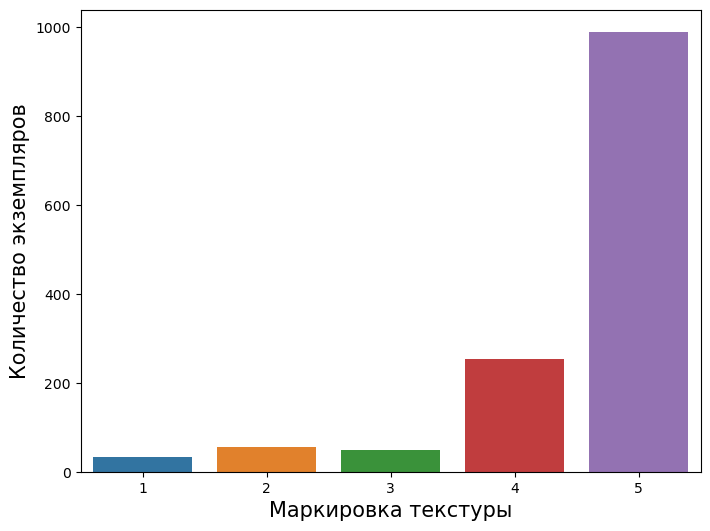

[34, 55, 50, 253, 990]

In [188]:
x = ['1', '2', '3', '4', '5']
df = pd.DataFrame(data = txtures_count, columns = ['Количество экземпляров'])
df['Метки'] = x

# Defining the plotsize
plt.figure(figsize=(8, 6))
 
# Defining the x-axis, the y-axis and the data
# from where the values are to be taken

plots = sns.barplot(x='Метки', y='Количество экземпляров', data=df)

# Setting the x-acis label and its size
plt.xlabel('Маркировка текстуры', size=15)
 
# Setting the y-axis label and its size
plt.ylabel('Количество экземпляров', size=15)
 
# Finallt plotting the graph
plt.show()

txtures_count

In [70]:
non_nodules.shape[0]/big_nodules.shape[0], non_nodules.shape[0]/small_nodules.shape[0], non_nodules.shape[0]/non_nodules.shape[0]

(3.5709117221418234, 1.263764404609475, 1.0)

In [272]:
textures = pd.read_csv('C:\\Users\\stan_\\lidc-idri-preproc\\diploma_work\\lidc_idri_preproc\\nods_3more')
textures['int_texture'] = [round(i) for i in textures['texture'].values]

In [16]:
textures[(textures['int_texture'] == 1)]

,Unnamed: 0,series_instance_uid,centroid,texture,int_texture
203,203,1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269...,"[370.7681319625067, 186.0066087582405, 93.9062...",1.000000,1
215,215,1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842...,"[203.4343451824674, 211.32380326053098, 99.196...",1.000000,1
230,230,1.3.6.1.4.1.14519.5.2.1.6279.6001.241717018262...,"[320.2144988344988, 364.94060606060606, 75.214...",1.000000,1
246,246,1.3.6.1.4.1.14519.5.2.1.6279.6001.975426625618...,"[376.96944832944837, 345.25547785547786, 121.8...",1.333333,1
320,320,1.3.6.1.4.1.14519.5.2.1.6279.6001.202283133206...,"[346.2013634509879, 182.8301593322424, 63.8393...",1.250000,1


In [19]:
textures[(textures['int_texture'] == 1)].shape

(34, 5)

In [25]:
int(Xn3m_t1p2.shape[0]*(2/10))

6

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
textures[(textures['int_texture'] == 1)]



for i in range(1, 6):
    Xn3m_t1p2, Xn3m_t1p1, n3m_t1p2, yn3m_t1p1 = train_test_split(textures[(textures['int_texture'] == i)], np.full((textures[(textures['int_texture'] == i)].shape[0],1), 0), test_size=0.1, random_state=42)
    np.save("Xn3m_t" + str(i) + "p1", Xn3m_t1p1)
    for j in range(9):
        Xn3m_t1p2[int(Xn3m_t1p2.shape[0]*(j/9)) : int(Xn3m_t1p2.shape[0]*(j+1/9))]

In [ ]:
Xn3m_t1p0 = np.load("Xn3m_t1p0.npy")
Xn3m_t1p1 = np.load("Xn3m_t1p1.npy")
Xn3m_t1p2 = np.load("Xn3m_t1p2.npy")
Xn3m_t1p3 = np.load("Xn3m_t1p3.npy")
Xn3m_t1p4 = np.load("Xn3m_t1p4.npy")
Xn3m_t1p5 = np.load("Xn3m_t1p5.npy")
Xn3m_t1p6 = np.load("Xn3m_t1p6.npy")
Xn3m_t1p7 = np.load("Xn3m_t1p7.npy")
Xn3m_t1p8 = np.load("Xn3m_t1p8.npy")
Xn3m_t2p0 = np.load("Xn3m_t2p0.npy")
Xn3m_t2p1 = np.load("Xn3m_t2p1.npy")
Xn3m_t2p2 = np.load("Xn3m_t2p2.npy")
Xn3m_t2p3 = np.load("Xn3m_t2p3.npy")
Xn3m_t2p4 = np.load("Xn3m_t2p4.npy")
Xn3m_t2p5 = np.load("Xn3m_t2p5.npy")
Xn3m_t2p6 = np.load("Xn3m_t2p6.npy")

print(Xn3m_t1p0.shape)
print(Xn3m_t1p1.shape)
print(Xn3m_t1p2.shape)
print(Xn3m_t1p3.shape)
print(Xn3m_t1p4.shape)
print(Xn3m_t1p5.shape)
print(Xn3m_t1p6.shape)
print(Xn3m_t1p7.shape)
print(Xn3m_t1p8.shape)
print(Xn3m_t2p0.shape)
print(Xn3m_t2p1.shape)
print(Xn3m_t2p2.shape)
print(Xn3m_t2p3.shape)
print(Xn3m_t2p4.shape)
print(Xn3m_t2p5.shape)
print(Xn3m_t2p6.shape)

In [131]:
#d < 3 mm
aug_smnds = []
for i in range(non_nodules.shape[0] - small_nodules_normalize.shape[0]):
    ind = random.randrange(small_nodules_normalize.shape[0])
    aug_smnds.append(augm(image=small_nodules_normalize[ind])['image'])

In [137]:
fin_sm_nods = np.concatenate((small_nodules_normalize, np.array(aug_smnds)), axis = 0)
#np.save('small_nodules_aug', fin_sm_nods)

In [138]:
X = np.concatenate((np.array(txtures_aug), fin_sm_nods, non_nodules_normalize), axis = 0)
#np.save('X', X)

In [148]:
np.load('X.npy').shape

(14490, 32, 32, 16)

In [144]:
y = np.concatenate((np.full((np.array(txtures_aug).shape[0],1), 0), np.full((fin_sm_nods.shape[0],1), 1), np.full((non_nodules_normalize.shape[0],1), 2)), axis = 0)

In [2]:
txtures_count

NameError: name 'txtures_count' is not defined

In [3]:
#d > 3
txtures_count = [textures[textures['int_texture'] == i].count()['Unnamed: 0'] for i in range(1, 6)]
mult = non_nodules.shape[0]//5
txtures_aug = []
for i in range(big_nodules_normalize.shape[0]):
    t = textures[textures.index == i]['int_texture'].values[0]
    txtures_aug.append(big_nodules_normalize[i])
    for j in range(mult//txtures_count[t-1] - 1):
        g = augm(image=big_nodules_normalize[i])['image']
        txtures_aug.append(g)
        print(type(txtures_aug[-1]))
        print(txtures_aug[-1].shape)

NameError: name 'textures' is not defined

In [126]:
#np.save('big_nodules_aug', np.array(txtures_aug))

In [88]:
s = 0
for i in txtures_aug:
    s += len(i)

In [90]:
len(txtures_aug)

4625

In [59]:
big_nodules_normalize.shape, small_nodules 

(1382, 32, 32, 16)

In [34]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

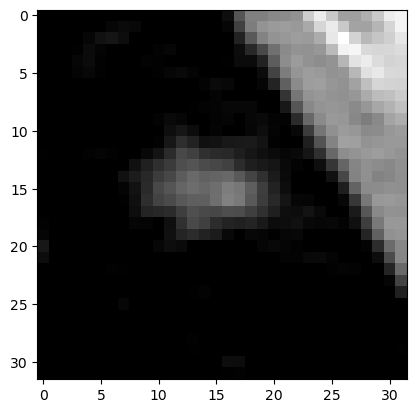

In [46]:
plt.imshow(image[:, :, 8], 'gray')

In [ ]:

fig = plt.figure()
for n, (image, title) in enumerate(zip(images, titles)):
    a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
    if image.ndim == 2:
        plt.gray()
    
    a.set_title(title)
fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
plt.show()

In [36]:
show_images(image[:, :, :12], 32)

ValueError: Number of columns must be a positive integer, not 1.0

<Figure size 640x480 with 0 Axes>